<a href="https://colab.research.google.com/github/SeongJae999/AIFFEL_quest_cr/blob/main/Exploration/Sub%20Quest%20C24/Laplacian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install kornia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.4/899.4 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.8 MB/s eta 0:00:00


In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from transformers import AutoModelForImageSegmentation

model = AutoModelForImageSegmentation.from_pretrained('briaai/RMBG-2.0', trust_remote_code=True)
torch.set_float32_matmul_precision(['high', 'highest'][0])
# model.to('cuda')
# model.eval()

config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

BiRefNet_config.py:   0%|          | 0.00/298 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/briaai/RMBG-2.0:
- BiRefNet_config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


birefnet.py:   0%|          | 0.00/91.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/briaai/RMBG-2.0:
- birefnet.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.10/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


model.safetensors:   0%|          | 0.00/885M [00:00<?, ?B/s]

In [7]:
torch.save(model.state_dict(), 'model.pt')

In [11]:
def transform_image(image):
    # Convert RGBA to RGB if image has alpha channel
    if image.mode == 'RGBA':
        image = image.convert('RGB')

    image_size = (1024, 1024)
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    return transform(image)

# Usage
input_image_path = "/content/liz.png"
image = Image.open(input_image_path)
print(image.size)
input_images = transform_image(image).unsqueeze(0)

(500, 611)


In [12]:
# Prediction
with torch.no_grad():
    preds = model(input_images)[-1].sigmoid().cpu()
pred = preds[0].squeeze()
pred_pil = transforms.ToPILImage()(pred)
mask = pred_pil.resize(image.size)
image.putalpha(mask)

image.save("no_bg_image.png")

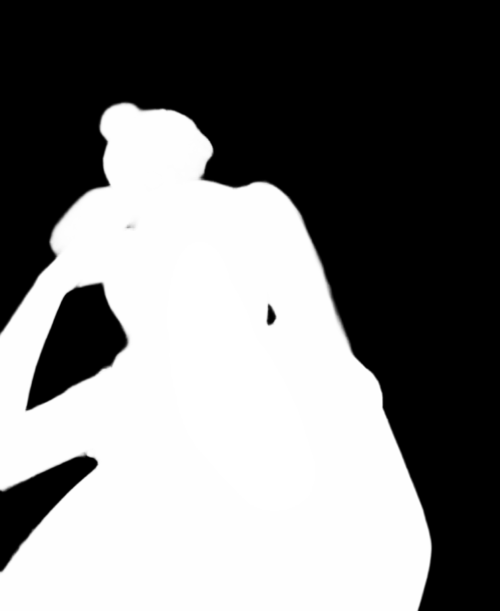

In [13]:
mask

(611, 500, 3)


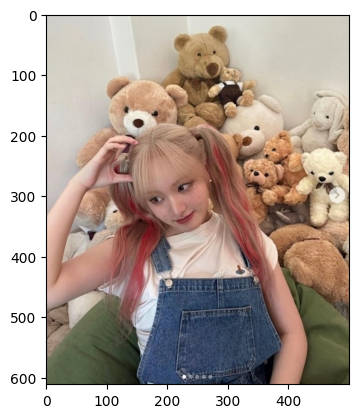

In [14]:
import cv2
import matplotlib.pyplot as plt

img_orig = cv2.imread(input_image_path)

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

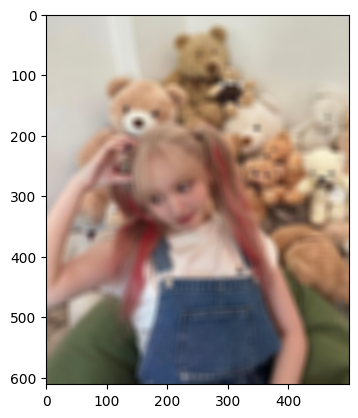

In [15]:
img_blurred = cv2.blur(img_orig, (13, 13))

plt.imshow(cv2.cvtColor(img_blurred, cv2.COLOR_BGR2RGB))
plt.show()

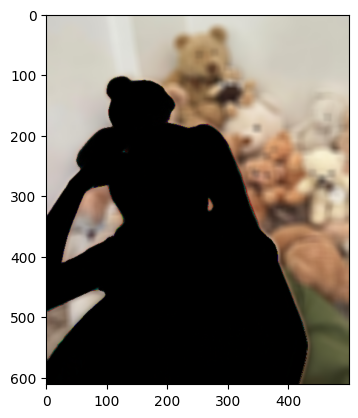

In [16]:
import numpy as np

np_mask = np.array(mask)

img_mask_color = cv2.cvtColor(np_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_blurred, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

In [17]:
np.unique(img_mask_color)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

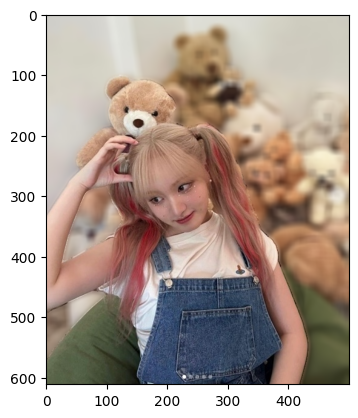

In [18]:
img_concat = np.where(img_mask_color>0, img_orig, img_blurred)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

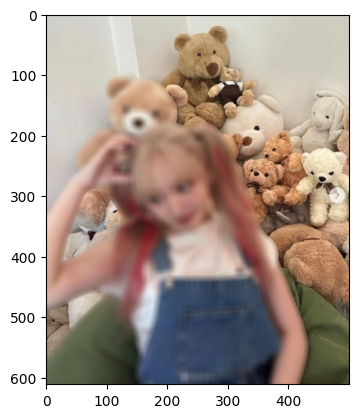

In [19]:
img_concat = np.where(img_mask_color==0, img_orig, img_blurred)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [23]:
from google.colab.patches import cv2_imshow

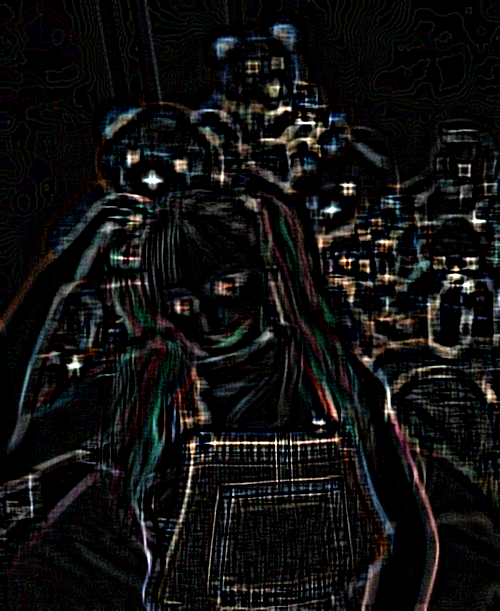

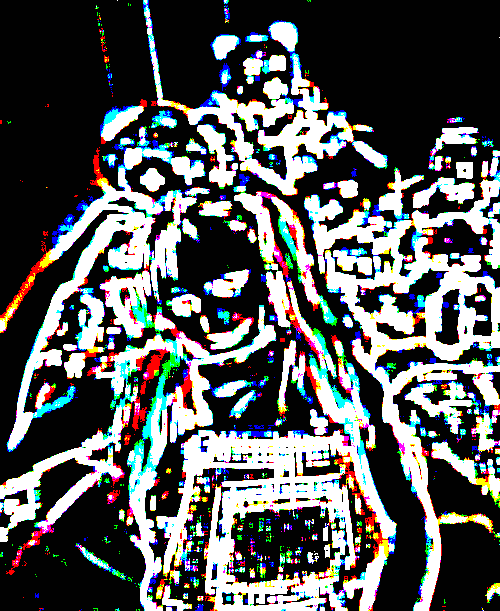

In [59]:
# 라플라스 필터 적용
laplacian = cv2.Laplacian(img_blurred, cv2.CV_8U, ksize=5)

# 라플라시안 필터 적용된 이미지에서, 각 값들의 제곱을 구함
dst = cv2.sqrBoxFilter(laplacian, ddepth=-1, ksize=(5,5), normalize=True)

# 분산을 구함 = 제곱의 평균 - 평균의 제곱
z = (dst - (laplacian*laplacian))

# blurred 처리되었다고 판단할 기준값 설정

threshold = 350
z[z<=threshold] = 1

# 결과 이미지 출력
cv2_imshow(laplacian)

cv2_imshow(z)

In [60]:
cv2.imwrite('laplacian_image.png', img_blurred) # 라플라스 필터 적용 이미지 저장

True

In [61]:
image = Image.open('/content/laplacian_image.png')
input_images = transform_image(image).unsqueeze(0)

# Prediction
with torch.no_grad():
    preds = model(input_images)[-1].sigmoid().cpu()
pred = preds[0].squeeze()
pred_pil = transforms.ToPILImage()(pred)
mask = pred_pil.resize(image.size)
image.putalpha(mask)

image.save("bg_blur_image.png")

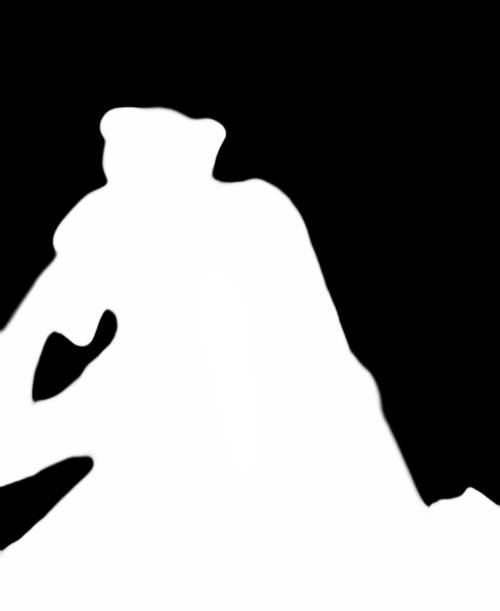

In [63]:
mask

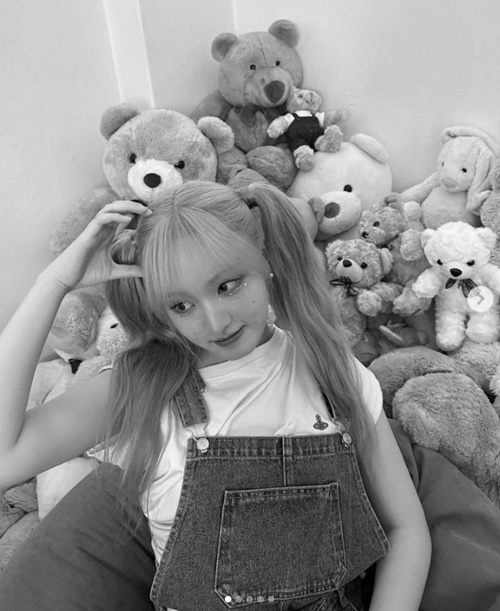

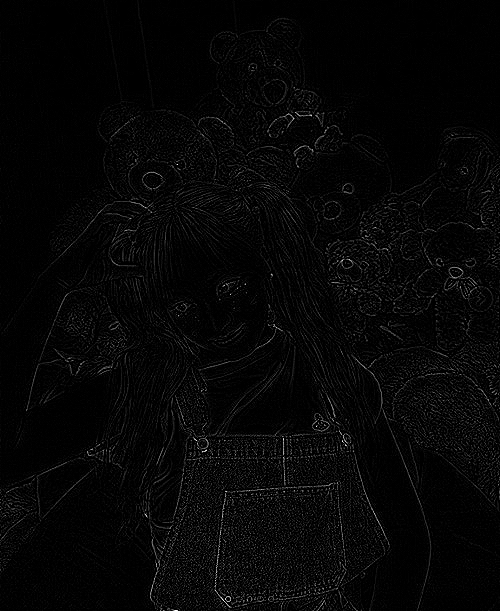

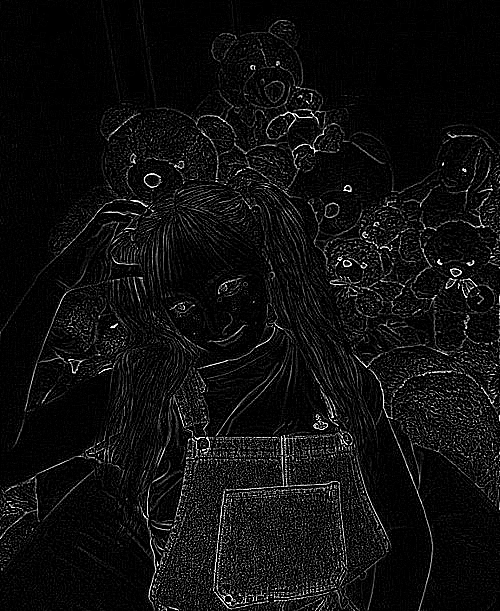

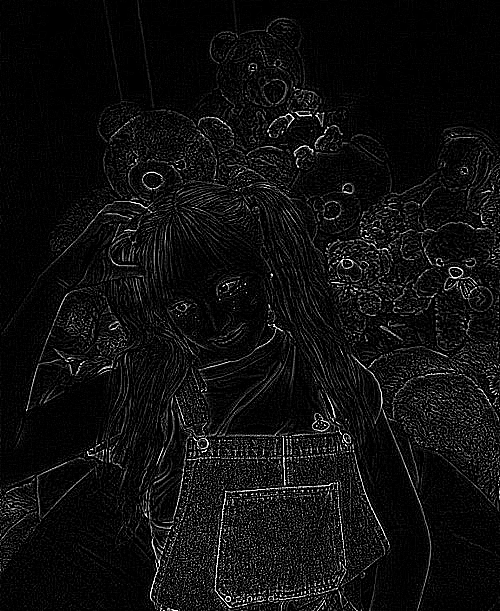

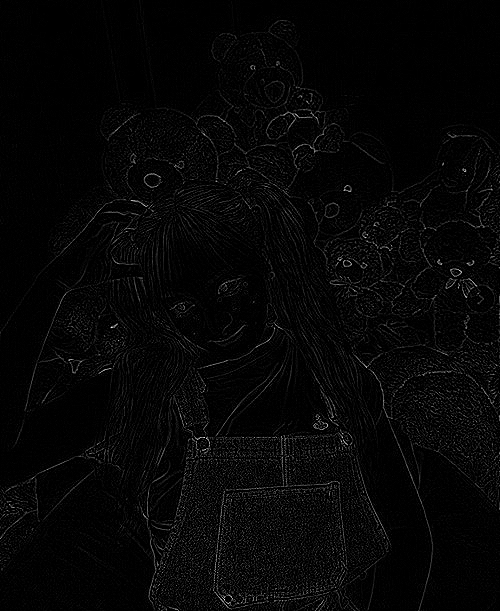

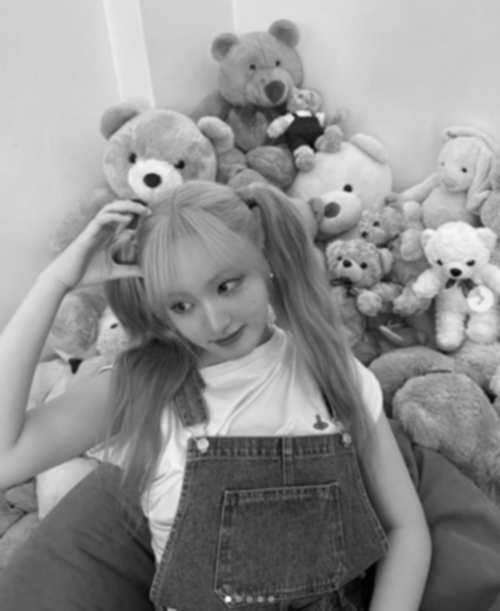

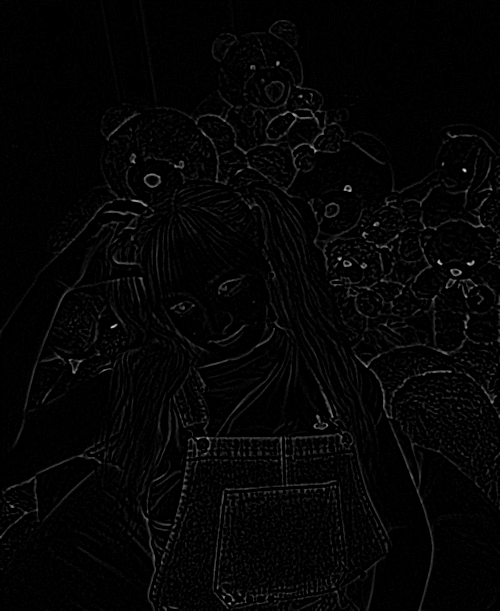

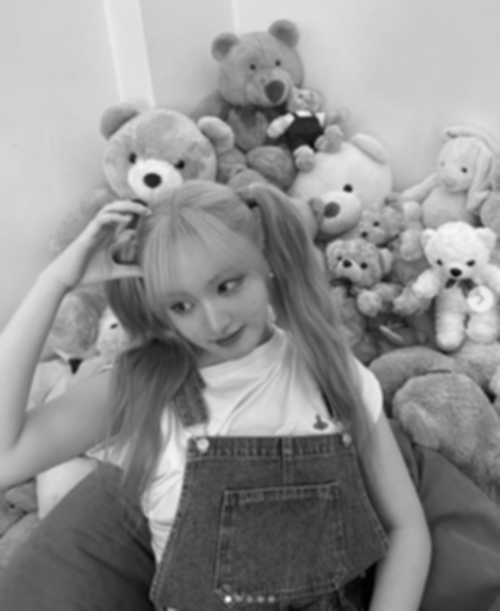

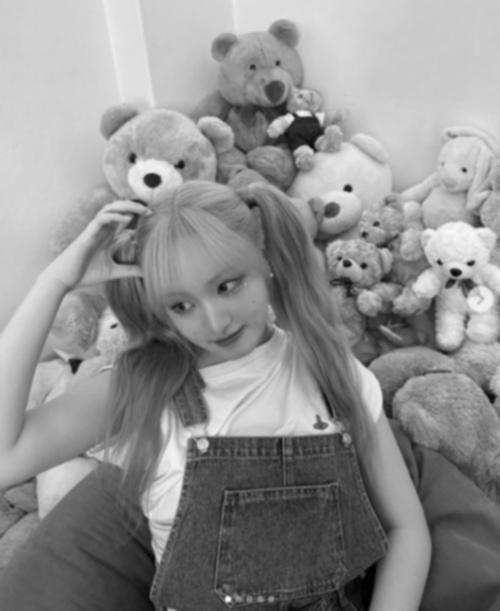

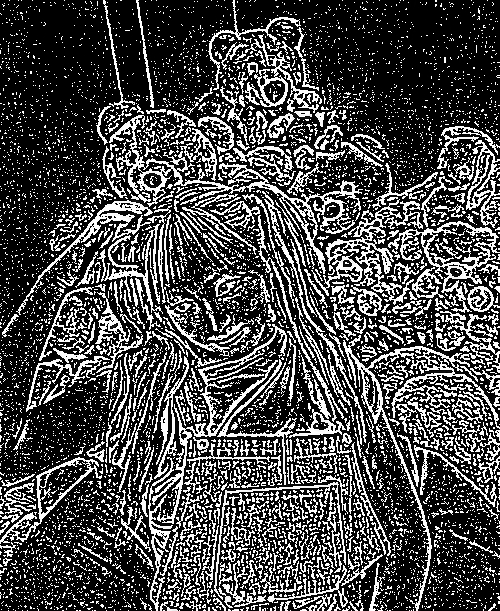

In [72]:
def laplacian():
    img = cv2.imread('/content/liz.png')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    height, width = gray.shape

    # 위의 그림과 같은 라플라시안 마스크를 생성
    # 마지막 laplacian4는 라플라시안 함수를 적용한 필터
    mask1 = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    mask2 = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]])
    mask3 = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
    laplacian1 = cv2.filter2D(gray, -1, mask1)
    laplacian2 = cv2.filter2D(gray, -1, mask2)
    laplacian3 = cv2.filter2D(gray, -1, mask3)
    laplacian4 = cv2.Laplacian(gray, -1)

    gaussian = cv2.GaussianBlur(gray, (5, 5), 0)
    LoG = cv2.filter2D(gaussian, -1, mask2)

    # 가우시안 1과 가우시안2의 알파값을 1.6 : 1 비율로 지정한다.
    gaussian1 = cv2.GaussianBlur(gray, (5, 5), 1.6)
    gaussian2 = cv2.GaussianBlur(gray, (5, 5), 1)
    DoG = np.zeros_like(gray)
    for i in range(height):
        for j in range(width):
            DoG[i][j] = float(gaussian1[i][j]) - float(gaussian2[i][j])

    # 출력된 이미지들을 png파일로 저장하기
    # plt.savefig()를 사용하려면 plt.show()를 사용하면 안된다. 둘 중 하나만 사용가능하다고 함

    cv2_imshow(gray)
    cv2.imwrite('/content/filter/gray.png', gray)

    cv2_imshow(laplacian1)
    cv2.imwrite('/content/filter/laplacian1.png', laplacian1)

    cv2_imshow(laplacian2)
    cv2.imwrite('/content/filter/laplacian2.png', laplacian2)

    cv2_imshow(laplacian3)
    cv2.imwrite('/content/filter/laplacian3.png', laplacian3)

    cv2_imshow(laplacian4)
    cv2.imwrite('/content/filter/laplacian4.png', laplacian4)

    cv2_imshow(gaussian)
    cv2.imwrite('/content/filter/gaussian.png', gaussian)

    cv2_imshow(LoG)
    cv2.imwrite('/content/filter/LoG.png', LoG)

    cv2_imshow(gaussian1)
    cv2.imwrite('/content/filter/gaussian1.png', gaussian1)

    cv2_imshow(gaussian2)
    cv2.imwrite('/content/filter/gaussian2.png', gaussian2)

    cv2_imshow(DoG)
    cv2.imwrite('/content/filter/DoG.png', DoG)

    return gray, laplacian1, laplacian2, laplacian3, laplacian4, gaussian, LoG, gaussian1, gaussian2, DoG

# 리턴값을 변수에 할당한다.
gray, laplacian1, laplacian2, laplacian3, laplacian4, gaussian, LoG, gaussian1, gaussian2, DoG = laplacian()

In [79]:
import glob

for file in glob.iglob('/content/filter/*.png'):
    image = Image.open(file)
    if image.mode == 'L':  # 이미지가 흑백인지 확인
        image = image.convert('RGB')
    input_images = transform_image(image).unsqueeze(0)

    # Prediction
    with torch.no_grad():
        preds = model(input_images)[-1].sigmoid().cpu()
    pred = preds[0].squeeze()
    pred_pil = transforms.ToPILImage()(pred)
    mask = pred_pil.resize(image.size)
    image.putalpha(mask)

    image.save(file.replace('/content/filter/',''))

In [ ]:
import glob

# 모델에 이미지를 입력
def model():
    outPut = []

    for file in glob.iglob(path+'/*.png'):
        segvalues, output = model.segmentAsPascalvoc(file)
        plt.title(file.replace(path+'/',''))
        plt.imshow(output)
        plt.show()

        outPut.append(output)

        for class_id in segvalues['class_ids']:
            print(LABEL_NAMES[class_id])

    return outPut

outPut = model()